<a href="https://colab.research.google.com/github/Archi2903/AI-in-Engenery/blob/main/AI%20GEMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Energy resources and artificial intelligence[202502-ENR4320-001]
22251844 이도윤

Denoising TEM Data with Autoencoder CNN and  Recover Geology profile

Dataset saved to: tdem_synthetic_dataset_v2.csv


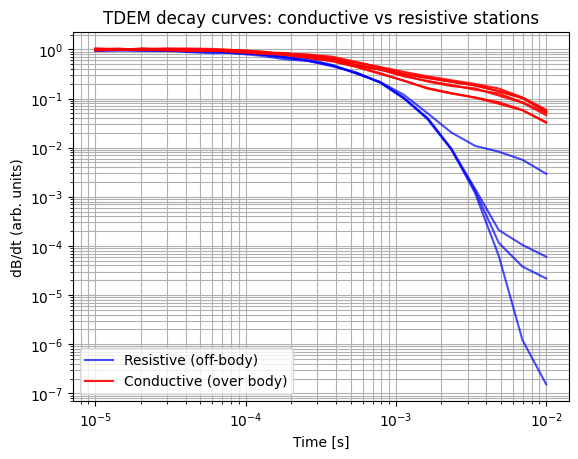

Test accuracy: 1.000


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 1. Geometry


def build_survey_geometry(
    x_min=0.0,
    x_max=300.0,
    dx=10.0,
    z_min=0.0,
    z_max=200.0,
):
    """
    Build 2D survey geometry.

    Profile: from x_min to x_max with spacing dx.
    Depth range is kept for documentation only.
    """
    stations_x = np.arange(x_min, x_max + dx, dx)

    geometry = {
        "x_min": x_min,
        "x_max": x_max,
        "dx": dx,
        "z_min": z_min,
        "z_max": z_max,
    }
    return stations_x, geometry


def define_ore_body(
    x_min=70.0,
    x_max=130.0,
    z_top=0.0,
    z_bottom=100.0,
):
    """
    Define a high-conductivity ore body (rectangular block).
    """
    ore_center_x = 0.5 * (x_min + x_max)
    ore_center_z = 0.5 * (z_top + z_bottom)

    ore = {
        "x_min": x_min,
        "x_max": x_max,
        "z_top": z_top,
        "z_bottom": z_bottom,
        "center_x": ore_center_x,
        "center_z": ore_center_z,
        "half_width": 0.5 * (x_max - x_min),
    }
    return ore



# 2. Time channels (TDEM times)


def build_time_channels(
    t_min=1e-5,
    t_max=1e-2,
    n_times=20,
    log_spacing=True,
):
    """
    Build time channels for Time Domain EM response.
    """
    if log_spacing:
        times = np.logspace(np.log10(t_min), np.log10(t_max), n_times)
    else:
        times = np.linspace(t_min, t_max, n_times)
    return times



# 3. Ore influence (how strongly the conductor affects a station)


def ore_weight_horizontal(x_station, ore, transition=10.0):
    """
    Smooth horizontal weight describing how much the ore body
    affects a given station.

    - weight ~ 1.0 for stations directly above the ore body
    - weight ~ 0.0 far away
    - 'transition' controls how smooth the edge is (in meters).

    We use a logistic function around the ore boundaries so that
    stations just outside the body still show weak conductivity.
    """
    cx = ore["center_x"]
    hw = ore["half_width"]

    dist = np.abs(x_station - cx)

    # logistic around the half-width boundary
    # dist < hw  -> weight ~ 1
    # dist > hw  -> weight decays to 0
    w = 1.0 / (1.0 + np.exp((dist - hw) / transition))
    return w


def depth_sensitivity_vs_time(times, t0=1e-3, sharpness=0.7):
    """
    Approximate depth / time sensitivity curve.

    For TDEM, early times are more sensitive to shallow structures,
    and later times are more sensitive to deeper conductors.

    Here we use a logistic in log10(t) so that:
    - for very early times: sensitivity ~ 0 (ore has little effect)
    - around t0: sensitivity starts to grow
    - for late times: sensitivity ~ 1
    """
    logt = np.log10(times)
    logt0 = np.log10(t0)
    sens = 1.0 / (1.0 + np.exp(-(logt - logt0) / sharpness))
    return sens


# 4. Synthetic TDEM curve


def synthetic_tdem_curve(
    times,
    ore_weight,
    noise_level=0.03,
    random_state=None,
):
    """
    Generate a synthetic dB/dt decay curve.

    Physics-inspired but still simple:
    - A resistive half-space gives a fast exponential decay.
    - A conductive body adds a slower exponential tail that is
      weighted by (ore_weight * depth_sensitivity(time)).

    Because the slow tail dominates at later times, stations above
    the ore body show a "slowly decaying" curve (conductive),
    while stations away from the body show a fast decay (resistive).
    """
    if random_state is None:
        rng = np.random.default_rng()
    else:
        rng = random_state

    # Background (resistive) component
    A_bg = 1.0           # amplitude
    tau_bg = 5e-4        # fast time constant (resistive)

    # Conductive body component (slow decay)
    A_cond = 0.6         # amplitude of conductor
    tau_cond = 5e-3      # slow time constant (conductive)

    # Depth sensitivity (only later times see the ore body)
    depth_sens = depth_sensitivity_vs_time(times)

    # Effective amplitude of the conductor term at each time
    # ore_weight controls lateral effect; depth_sens controls vertical effect
    A_cond_eff = ore_weight * depth_sens * A_cond

    # Clean (noise-free) signal
    signal_clean = (
        A_bg * np.exp(-times / tau_bg) +
        A_cond_eff * np.exp(-times / tau_cond)
    )

    # Add relative Gaussian noise
    noise = rng.normal(loc=0.0, scale=noise_level, size=times.shape)
    signal_noisy = signal_clean * (1.0 + noise)

    # Ensure positive values for log-plots and ML features
    signal_noisy = np.clip(signal_noisy, 1e-15, None)
    signal_clean = np.clip(signal_clean, 1e-15, None)

    return signal_noisy, signal_clean


# 5. Dataset generation


def generate_tdem_dataset(
    seed=42,
    save_csv=True,
    csv_filename="tdem_synthetic_dataset_v2.csv",
):
    """
    Generate a synthetic TDEM dataset for a 2D profile with a
    high-conductivity body.

    - Profile: 0..300 m, stations every 10 m
    - Ore body: 70..130 m in x, 0..100 m in depth
    - Output:
        data: dictionaries with arrays
        df:   pandas DataFrame with noisy responses for each station
    """
    rng = np.random.default_rng(seed)

    # 1) Geometry
    stations_x, geometry = build_survey_geometry()

    # 2) Ore body
    ore = define_ore_body()

    # 3) Time channels
    times = build_time_channels()

    n_stations = stations_x.size
    n_times = times.size

    responses_noisy = np.zeros((n_stations, n_times))
    responses_clean = np.zeros((n_stations, n_times))
    ore_weights = np.zeros(n_stations)
    labels_over_ore = np.zeros(n_stations, dtype=int)

    for i, x in enumerate(stations_x):
        w = ore_weight_horizontal(x, ore, transition=10.0)
        ore_weights[i] = w

        sig_noisy, sig_clean = synthetic_tdem_curve(
            times=times,
            ore_weight=w,
            noise_level=0.03,
            random_state=rng,
        )

        responses_noisy[i, :] = sig_noisy
        responses_clean[i, :] = sig_clean

        # Binary label: station directly above the ore body
        if ore["x_min"] <= x <= ore["x_max"]:
            labels_over_ore[i] = 1
        else:
            labels_over_ore[i] = 0

    # ---- Build DataFrame (noisy responses) ----
    time_columns = [f"t_{i:02d}" for i in range(n_times)]
    df = pd.DataFrame(responses_noisy, columns=time_columns)
    df.insert(0, "x", stations_x)
    df["label_over_ore"] = labels_over_ore
    df["ore_weight"] = ore_weights

    if save_csv:
        df.to_csv(csv_filename, index=False)
        print(f"Dataset saved to: {csv_filename}")

    data = {
        "x": stations_x,
        "times": times,
        "response_noisy": responses_noisy,
        "response_clean": responses_clean,
        "geometry": geometry,
        "ore": ore,
        "ore_weight": ore_weights,
        "labels_over_ore": labels_over_ore,
    }
    return data, df


# 6. Visualization: curves over conductor vs outside


def plot_conductive_vs_resistive(data, n_examples_each=3):
    """
    Plot example curves for:
    - stations over the conductive body
    - stations far from the body (background / resistive)

    You should see:
    - blue (resistive): fast decay
    - red  (conductive): slower decay, higher values at late times
    """
    x = data["x"]
    times = data["times"]
    resp = data["response_noisy"]
    ore = data["ore"]

    # Indices over the ore body
    over = np.where((x >= ore["x_min"]) & (x <= ore["x_max"]))[0]
    off = np.where((x < ore["x_min"] - 20) | (x > ore["x_max"] + 20))[0]

    over = over[::max(1, len(over) // n_examples_each)]
    off = off[::max(1, len(off) // n_examples_each)]

    plt.figure()
    # Resistive / background
    for idx in off:
        plt.loglog(times, resp[idx, :], "b-", alpha=0.7,
                   label="Resistive (off-body)" if idx == off[0] else None)

    # Conductive / over ore
    for idx in over:
        plt.loglog(times, resp[idx, :], "r-", alpha=0.9,
                   label="Conductive (over body)" if idx == over[0] else None)

    plt.xlabel("Time [s]")
    plt.ylabel("dB/dt (arb. units)")
    plt.title("TDEM decay curves: conductive vs resistive stations")
    plt.legend()
    plt.grid(True, which="both")
    plt.show()



# 7. Simple ML example: learn to detect conductive body

def train_simple_classifier(data, n_epochs=200):
    """
    Train a very simple neural network that looks at one TDEM curve
    and predicts if the station is above the conductive body (1)
    or outside (0).

    This is just an example of how to 'learn on these data'.
    """
    import tensorflow as tf
    from tensorflow.keras import layers, models

    X = data["response_noisy"].copy()
    y = data["labels_over_ore"].astype(float)

    # Use log-response as features (more linear in time)
    X = np.log10(X)
    X_mean = X.mean(axis=0, keepdims=True)
    X_std = X.std(axis=0, keepdims=True) + 1e-12
    X = (X - X_mean) / X_std

    # Train / test split (70/30)
    n = X.shape[0]
    n_train = int(0.7 * n)
    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]

    model = models.Sequential([
        layers.Input(shape=(X.shape[1],)),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=n_epochs,
        verbose=0,
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.3f}")

    return model, history


# 8. Run everything


if __name__ == "__main__":
    # Generate synthetic data
    data, df = generate_tdem_dataset(
        seed=123,
        save_csv=True,
        csv_filename="tdem_synthetic_dataset_v2.csv",
    )

    # Visual check: conductive vs resistive curves
    plot_conductive_vs_resistive(data, n_examples_each=4)

    # Train a simple classifier on the curves
    model, history = train_simple_classifier(data, n_epochs=200)


Dataset saved to: tdem_synthetic_dataset_v2.csv


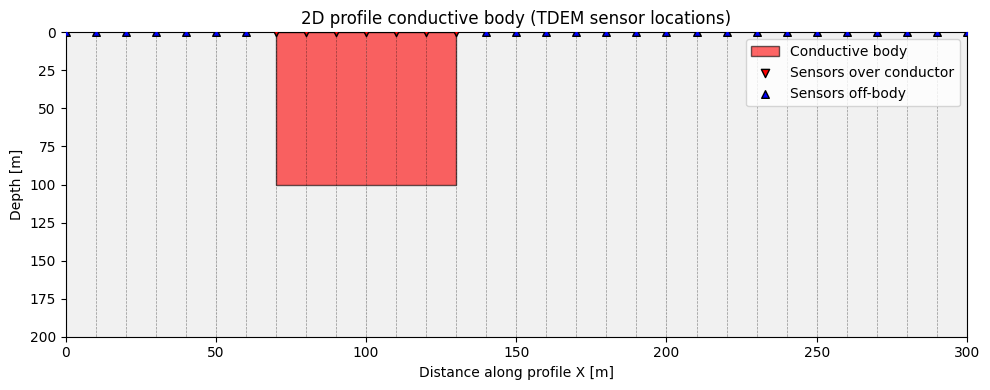

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_2d_section_with_sensors(data):
    """
    Plot a 2D cross-section (x vs depth) with:
      - conductive body as a colored rectangle
      - sensor locations on the surface
      - thin dashed vertical lines from each sensor downwards

    Parameters
    ----------
    data : dict
        Output dictionary from generate_tdem_dataset().
    """
    x = data["x"]
    ore = data["ore"]
    geom = data["geometry"]

    x_min, x_max = geom["x_min"], geom["x_max"]
    z_min, z_max = geom["z_min"], geom["z_max"]

    labels = data["labels_over_ore"]  # 1 = over conductor, 0 = outside

    fig, ax = plt.subplots(figsize=(10, 4))

    # --- background (host rock) ---
    ax.fill_between([x_min, x_max], z_max, z_min,
                    color="lightgrey", alpha=0.3)

    # --- conductive ore body (rectangle) ---
    width = ore["x_max"] - ore["x_min"]
    height = ore["z_bottom"] - ore["z_top"]

    rect = plt.Rectangle(
        (ore["x_min"], ore["z_top"]),  # (x0, z0)
        width,
        height,
        facecolor="red",
        edgecolor="k",
        alpha=0.6,
        label="Conductive body",
    )
    ax.add_patch(rect)

    # --- sensor locations at surface (z = 0) ---
    over_mask = labels == 1
    off_mask = ~over_mask

    # Sensors over the conductor (red markers)
    ax.scatter(
        x[over_mask],
        np.zeros_like(x[over_mask]),
        marker="v",
        s=35,
        color="red",
        edgecolor="k",
        label="Sensors over conductor",
        zorder=3,
    )

    # Sensors outside the conductor (blue markers)
    ax.scatter(
        x[off_mask],
        np.zeros_like(x[off_mask]),
        marker="^",
        s=30,
        color="blue",
        edgecolor="k",
        label="Sensors off-body",
        zorder=3,
    )

    # --- thin dashed vertical lines (soundings) ---
    for xi in x:
        ax.plot(
            [xi, xi],
            [z_min, z_max],
            linestyle="--",
            linewidth=0.5,  # thin dashed line
            color="black",
            alpha=0.4,
        )

    # --- axis formatting ---
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(z_max, z_min)  # depth increases downward
    ax.set_xlabel("Distance along profile X [m]")
    ax.set_ylabel("Depth [m]")
    ax.set_title("2D profile conductive body (TDEM sensor locations)")

    ax.legend(loc="upper right")
    ax.grid(True, axis="x", linestyle=":", alpha=0.3)

    plt.tight_layout()
    plt.show()


# Пример использования вместе с генератором:
if __name__ == "__main__":
    data, df = generate_tdem_dataset(
        seed=123,
        save_csv=True,
        csv_filename="tdem_synthetic_dataset_v2.csv",
    )

    # 2D-разрез с сенсорами и пунктирными линиями
    plot_2d_section_with_sensors(data)
